In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal, stats, fftpack
# import mplcursors
from glob import glob
import time

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_stim_events
from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib notebook

#### Plot electrodes

### Load experiment

In [6]:
recfolder = r'W:\EEG_exp\mouse633552\opto_cortical_pt2_2022-09-01_13-04-57\experiment1\recording1'
exp = EEGexp(recfolder, preprocess=True, make_stim_csv=False)
# exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
Aligning timestamps for all datasets...
probeB AP and LFP
Creating W:\EEG_exp\mouse633552\opto_cortical_pt2_2022-09-01_13-04-57\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0\timestamps_master_clock.npy
Creating W:\EEG_exp\mouse633552\opto_cortical_pt2_2022-09-01_13-04-57\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.1\timestamps_master_clock.npy
probeC AP and LFP
Creating W:\EEG_exp\mouse633552\opto_cortical_pt2_2022-09-01_13-04-57\experiment1\probeC_sorted\continuous\Neuropix-PXI-100.0\timestamps_master_clock.npy
Creating W:\EEG_exp\mouse633552\opto_cortical_pt2_2022-09-01_13-04-57\experiment1\probeC_sorted\continuous\Neuropix-PXI-100.1\timestamps_master_clock.npy
probeF AP and LFP
Creating W:\EEG_exp\mouse633552\opto_cortical_pt2_2022-09-01_13-04-57\experiment1\probeF_sorted\continuous\Neuropix-PXI-100.0\timestamps_master_clock.npy
Creating W:\EEG_exp\mouse633552\opto_cortical_pt2_2022-09-01_13-04-57\experiment1\probeF_sorted\

In [7]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

opto_cortical_pt2


### Load EEG data and stimulus log

In [8]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

In [9]:
bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [10]:
stim_log = pd.read_csv(exp.stimulus_log_file)
# if 'good' not in stim_log.columns:
#     qualitycheck_trials(exp, known_bad_chs=bad_chs)
#     stim_log = pd.read_csv(exp.stimulus_log_file)

In [11]:
stim_log.head()

,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
0,opto,0,470nm,5,175.09153,175.14150,0.05,0
1,opto,1,470nm,5,181.13660,181.18657,0.05,0
2,opto,2,470nm,5,186.93173,186.98174,0.05,0
3,opto,3,470nm,5,192.89041,192.94038,0.05,0
4,opto,4,470nm,5,199.87865,199.92862,0.05,0


### Stim evoked traces

In [12]:
plot_before = 0.5 # s, look at 500 ms pre-stim
plot_after = 1.0 # s, look at 1000 ms post-stim

## Loop through all stim events/sweeps and collect traces
avg_traces = {}
for st_type in stim_log.stim_type.unique():
    avg_traces[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        avg_traces[st_type][parami] = {}
        
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        for sweepi in sweep_list:
            avg_traces[st_type][parami][sweepi] = {}
            print('{}, {}, sweep {:d}'.format(st_type, str(parami), sweepi))
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi)
            if len(events) == 0:
                print('no good trials found')
                continue
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
            comavg_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            
            ## Design Butterworth bandpass filter ##
            filtb, filta = signal.butter(
                3,
                np.array([0.1, 100])/(exp.ephys_params['EEG']['sample_rate']/2),
                btype='bandpass'
            )
            
            ## Store traces ##
            avg_traces[st_type][parami][sweepi]['raw'] = [event_ts, np.mean(event_traces, axis=2)]
            avg_traces[st_type][parami][sweepi]['filtered'] = [
                event_ts,
                np.mean(signal.filtfilt(filtb, filta, event_traces, axis=0), axis=2)
            ]
            avg_traces[st_type][parami][sweepi]['common_averaged'] = [
                event_ts,
                np.mean(signal.filtfilt(filtb, filta, comavg_traces, axis=0), axis=2)
            ]

470nm, 5, sweep 0
470nm, 5, sweep 1


### Plotting

<IPython.core.display.Javascript object>


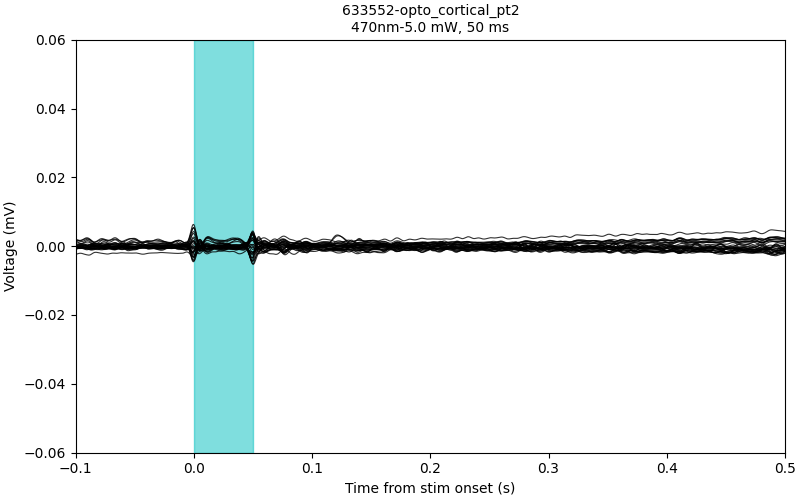

<IPython.core.display.Javascript object>


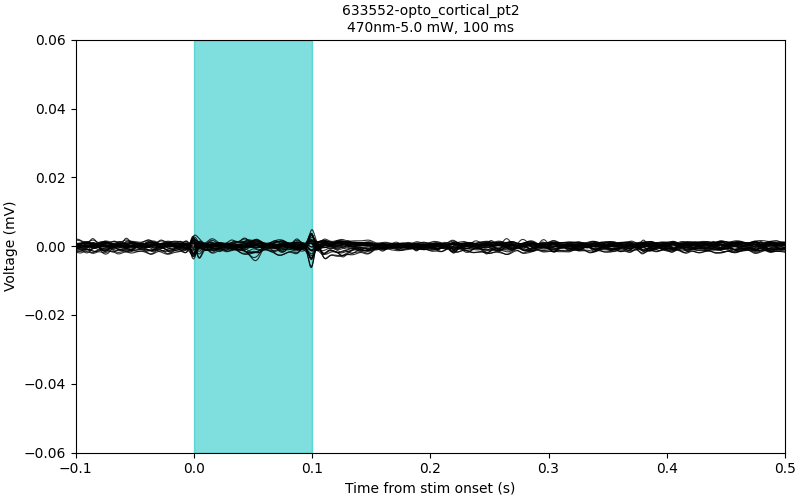

In [14]:
ylimit = 0.06 # mV, for visual 0.05
prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
plot_traces = 'common_averaged' # choose: 'raw', 'filtered', or 'common_averaged'
sweep_list = np.unique(stim_log['sweep'].values)

for sweepi in sweep_list:
    stim_list = stim_log[stim_log['sweep']==sweepi].stim_type.unique()
    for stimi in stim_list:
        param_list = stim_log[(stim_log['sweep']==sweepi) & (stim_log['stim_type']==stimi)].parameter.unique()
        for parami in param_list:
            eventdf = stim_log[(stim_log['sweep']==sweepi) & (stim_log['stim_type']==stimi) & (stim_log['parameter']==parami)]
            LEDdur = eventdf['duration'].values[0]
            
            timex = avg_traces[stimi][parami][sweepi][plot_traces][0]
            plottraces = avg_traces[stimi][parami][sweepi][plot_traces][1]
            pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))
            
            fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
            for chi in GOOD_CHS:
                ax.plot(timex[pinds], plottraces[pinds, chi]/1000, color='k', linewidth=0.8, alpha=0.8)
            ax.axvspan(0., LEDdur, color='c', alpha=0.5)

            ax.set_xlim([-prex, postx])
            ax.set_ylim([-ylimit, ylimit])
            ax.set_xlabel('Time from stim onset (s)')
            ax.set_ylabel('Voltage (mV)')
            ax.set_title('{}-{}\n{}-{:.1f} mW, {:d} ms'.format(exp.mouse, exp_tag, stimi, parami, round(LEDdur * 1E3)))

            ### SAVE: this will save the figure in the recording1 folder ###
            fig_name = 'ERP_{:.1f}mW_{:d}ms_{}.png'.format(parami, round(LEDdur * 1E3), exp_tag)
            fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Plot the visual evoked response across all electrodes. This plots all electrodes in the array layout, with bad chs in red. You can choose to plot:
- 'raw': raw signals, averaged across all trials
- 'filtered': bandpass filtered signals, averaged across all trials
- 'common_averaged': raw signals that have been common average referenced to all good chs, then filtered and averaged across all trials

<IPython.core.display.Javascript object>


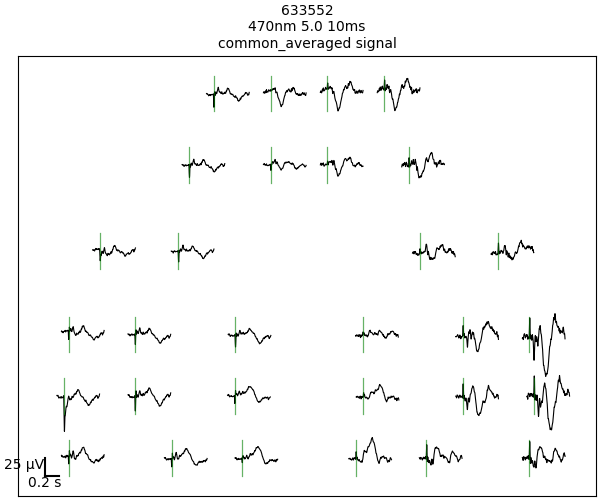

In [16]:
plot_stim_type = '470nm'
plot_stim_param = 5.0
plot_sweep = 9
LEDdur = 0.01
plot_traces = 'common_averaged' # choose: 'raw', 'filtered', or 'common_averaged'

prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 80 # changes vertical distance between traces, usually 100 for VEPs

timex = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][0]
plottraces = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][1]
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(
        timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        trace_color,
        linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
#     ax.plot([0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
#              0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
#             [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
#              25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
#             color='r', linewidth=0.9, alpha=0.6)
    if chi == 0:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.95
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\n{} {} 10ms\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE: this will save the figure in the recording1 folder ###
fig_name = 'arrERP_{:.1f}mW_{:d}ms_{}.png'.format(parami, round(LEDdur * 1E3), exp_tag)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

In [21]:
snr_dur = 0.2

binds = np.squeeze(np.argwhere((timex >= -snr_dur) & (timex < 0)))
rinds = np.squeeze(np.argwhere((timex > 0) & (timex <= snr_dur)))

base_power = np.mean(np.square(plottraces[binds, :]), axis=0)
resp_power = np.mean(np.square(plottraces[rinds, :]), axis=0)
snrs = np.sqrt(resp_power / base_power)
print(snrs)
print(np.mean(snrs))

[4.58888117 2.79008011 2.6650294  5.1919728  2.48958295 2.62788504
 3.04009313 2.4446252  1.86222429 3.0706533  2.51141067 3.11205445
 3.76049653 3.20753522 2.93549371 1.73380436 1.55948248 1.56991256
 1.70994152 1.78422732 2.00235811 1.6608437  2.99307016 2.34630104
 1.9764319  2.66087771 2.4323895  2.34167865 2.68162825 2.14774438]
2.596623654207896


#### Same plot above, but as a butterfly plot

<IPython.core.display.Javascript object>


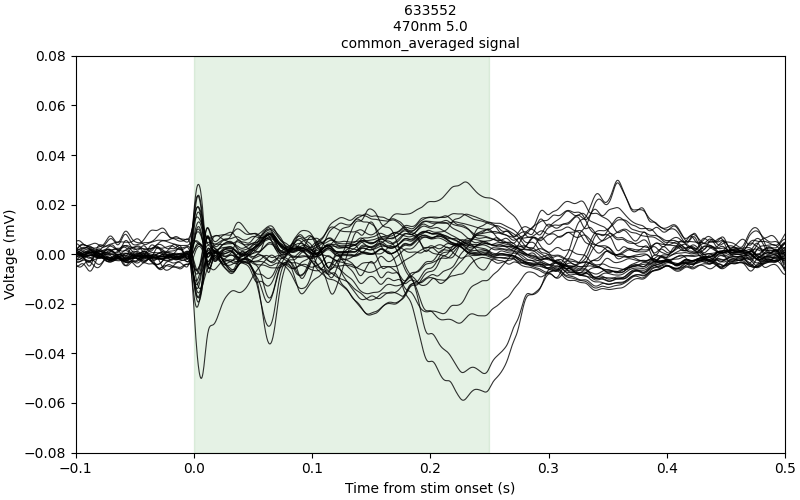

In [30]:
ylimit = 0.08 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
for chi in GOOD_CHS:
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000, color='k', linewidth=0.8, alpha=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_butterflyplot.png'.format(plot_traces, plot_stim_type, str(plot_stim_param))
# fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

#### Same plot, but with electrodes vertically stacked

<IPython.core.display.Javascript object>


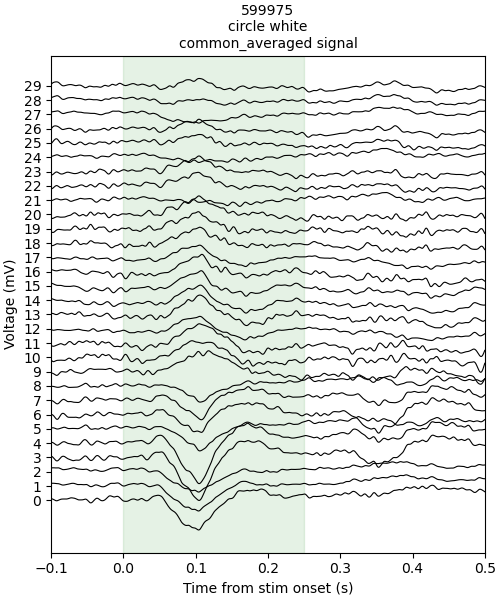

In [26]:
sep = 0.025 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(5, 6), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000 + sep*chi, color=trace_color, linewidth=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_xlabel('Time from stim onset (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(range(len(exp.EEG_channel_coordinates)))
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_stackedplot.png'.format(plot_traces, plot_stim_type, str(plot_stim_param))
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

### Plot whole traces

<IPython.core.display.Javascript object>


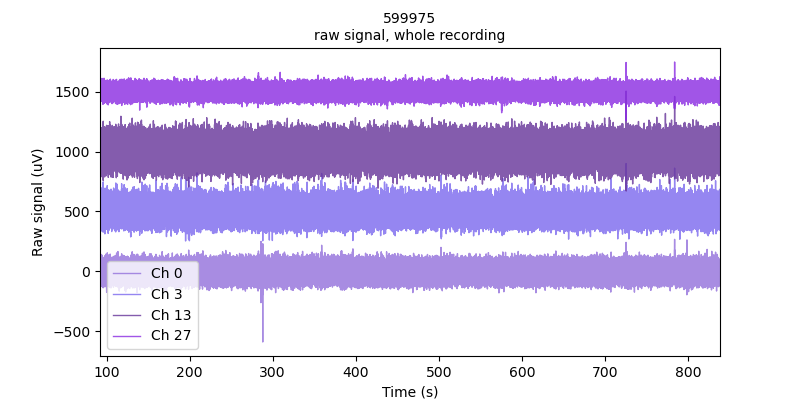

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [15]:
plot_chs = [0,3,13,27]
chcolors = ['mediumpurple','mediumslateblue','rebeccapurple','blueviolet','darkorchid','darkviolet']
# chcolors = ['crimson','blue','gold','green','darkviolet','deeppink']

offset = 500
fig, ax = plt.subplots(figsize=(8, 4))

for i, chi in enumerate(plot_chs):
    ax.plot(eeg_ts, eeg_data[:,chi] + i*offset, color=chcolors[i], linewidth=1, alpha=0.8, label=('Ch {:d}'.format(chi)))

ax.set_xlim((eeg_ts[0], eeg_ts[-1]))
# ax.set_ylim((-300, 1800))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw signal (uV)')
ax.set_title('{}\nraw signal, whole recording'.format(exp.mouse))
ax.legend()

### SAVE: this will save the figure in the recording1 folder ###
fig_name = 'whole_raw_signals.png'
fig.savefig(os.path.join(recfolder, fig_name), transparent=True)

### Look at spectrum of chs

In [18]:
frex, Pxx = signal.welch(
    eeg_data[:int(120 * exp.ephys_params['EEG']['sample_rate'])+1, :],
    exp.ephys_params['EEG']['sample_rate'],
    nperseg=2 * exp.ephys_params['EEG']['sample_rate'],
    axis=0
)

<IPython.core.display.Javascript object>


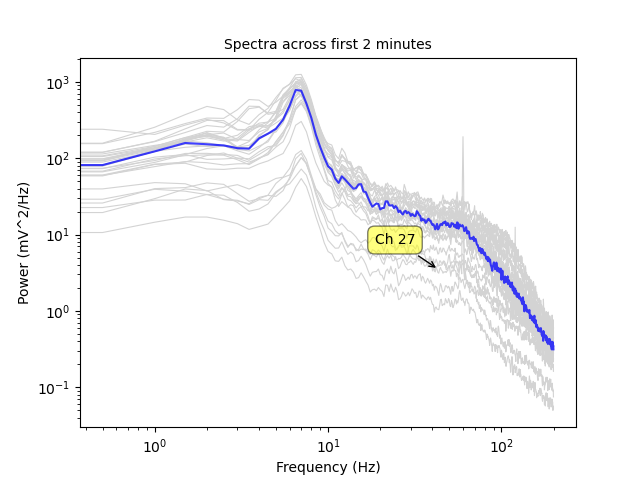

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [20]:
frinds = frex < 200

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(ind))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
# ax.set_xlim([0, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')

In [21]:
bad_chs = []
print(bad_chs)
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
BAD_CHS = np.array(bad_chs)

[]


<IPython.core.display.Javascript object>


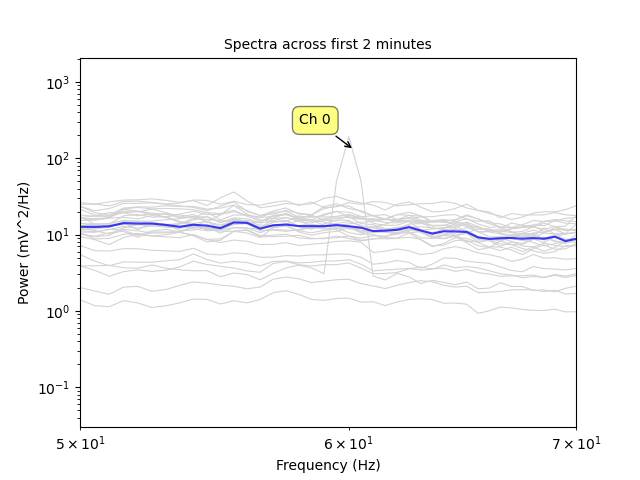

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [22]:
fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:][:,GOOD_CHS], color='lightgray', linewidth=0.8)
if BAD_CHS.size > 0:
    ax.loglog(frex[frinds], Pxx[frinds,:][:,BAD_CHS], color='r', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(GOOD_CHS[ind]))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx[:,GOOD_CHS], axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([50, 70])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')